# Real valued Turbo codes over AWGN channel

In [1]:
# Imports 
import py_itpp as pyp
from matplotlib import pyplot as plt

# BLER for uncoded over AWGN

In [2]:
def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = pyp.random.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator_ = pyp.modulator.modulator_1d()
    constellation = pyp.vec.vec('-1, 1')
    symbols = pyp.vec.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (pow(10, 0.1 * snr_db))
    noise = pyp.random.randn(tx_signal.length())
    noise *= pyp.elem_math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = pyp.error_counters.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

# BLER for Turbo over AWGN

In [3]:
def block_error_ratio_turbo_awgn(snr_db, interleaver_length):
  '''Create turbo_codec_instance'''
  codec = pyp.turbo.turbo_codec()
  
  '''Set codec parameters'''
  gen = pyp.vec.ivec(2)
  gen[0] = 11
  gen[1] = 13
  constraint_length = 4
  interleaver = pyp.vec.ivec('0, 19, 14, 33, 28, 47, 42, 13, 8, 27, 22, 41, 36, 7, 2, 21, 16, 35, 30, 1, 44, 15, 10, 29, 24, 43, 38, 9, 4, 23, 18, 37, 32, 3, 46, 17, 12, 31, 26, 45, 40, 11, 6, 25, 20, 39, 34, 5')
  codec.set_parameters(gen, gen, constraint_length, pyp.vec.ivec())
  codec.set_interleaver(interleaver)
  
  '''Generate random bits and encode them'''
  nrof_uncoded_bits = interleaver_length * 1000
  uncoded_bits = pyp.random.randb(nrof_uncoded_bits)
  encoded_bits = pyp.vec.bvec()
  codec.encode(uncoded_bits, encoded_bits)
  
  '''Modulate bits using BPSK'''
  symbols = pyp.vec.vec('1, -1')
  bits2symbol = pyp.vec.ivec('0, 1')
  modulator_ = pyp.modulator.modulator_1d(symbols, bits2symbol)
  tx_signal = modulator_.modulate_bits(encoded_bits)
  
  '''Add AWGN noise'''
  noise_variance = 1.0 / (pow(10, 0.1 * snr_db))
  noise = pyp.random.randn(tx_signal.length())
  noise *= pyp.elem_math.sqrt(noise_variance)
  rx_signal = tx_signal + noise
  
  '''Demodulate received signal (soft bits, LOGMAP)'''
  soft_bits = pyp.vec.vec()
  modulator_.demodulate_soft_bits(rx_signal, 
                                  noise_variance,
                                  soft_bits,
                                  pyp.modulator.soft_method.LOGMAP)

  '''Turbo decode the soft bits'''
  decoded_bits = pyp.vec.bvec()
  codec.decode(soft_bits, decoded_bits, pyp.vec.bvec())
    
  '''Count errors'''
  blerc = pyp.error_counters.BLERC(interleaver_length)
  blerc.count(decoded_bits, uncoded_bits)
  return blerc.get_errorrate()

# Run simulation

In [4]:
'''SNR range'''
snrs_db = range(-10, 10) 
block_size = 4

print('BLER for uncoded bits over AWGN channel')
bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]

print('BLER for Turbo coded  bits over AWGN channel, interleaver length 48 and code rate 0.33')
interleaver_length = 48
bler_turbo = [block_error_ratio_turbo_awgn(snr, interleaver_length) for snr in snrs_db]

BLER for uncoded bits over AWGN channel
BLER for Turbo coded  bits over AWGN channel, interleaver length 48 and code rate 0.33


# Plot results

Plotting results


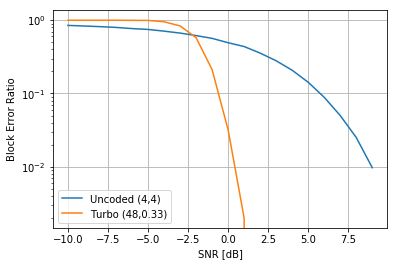

In [6]:
print('Plotting results')
plt.figure()
plt.grid(True)
plt.semilogy(snrs_db, bler_unc)
plt.semilogy(snrs_db, bler_turbo)
plt.xlabel('SNR [dB]')
plt.ylabel('Block Error Ratio')
plt.legend(['Uncoded (4,4)', 'Turbo (48,0.33)'], loc = 'lower left')
plt.show()